# 동적자산 배분

## DAA (Defensive Asset Allocation)
12개 ETF 중 상대 모멘텀을 통해 최근 많이 오른 ETF를 사고, VAA와 마찬가지로 1-3-6-12 모멘텀 스코어를 활용합니다. 안전 자산 3개도 VAA와 같습니다. 다만 광폭 모멘텀으로 MDD를 줄이는 VAA와 달리 카나리아 자산군을 통해 MDD를 줄임과 동시에 안전자산 보유 비중을 줄입니다.

- VAA와 비슷하게 수익을 내지만 카나리아 자산군 도입으로 MDD를 줄임과 동시에 안전자산 비중을 축소해서 수익을 극대화 합니다.

### 포함자산
 - 공격형 자산 : 미국 대형주(SPY), 나스탁(QQQ), 미국 소형주(IWM), 유럽 주식(VGK), 일본주식 (EWJ), 개발도상국 주식(EEM), 미국 부동산리츠(VNQ), 금(GLD), 원자재(DBC), 하이일드 채권(HYG), 미국 회사채(LQD), 미국 장기채(TLT)
 - 안전 자산 : 안전 자산 : 미국 회사채(LQD), 미국 중기국채(IEF), 미국 단기국채(SHY)

### 매수 전략
 - 카나리아 자산군(VWO, BND)으로 공격형 자산의 비중을 결정\
     VWO, BND 둘 다 모멘텀 스코어가 0 이상 : 100%\
     VWO, BND 둘 중 하나가 0 이상 : 50%\
     VWO, BND 둘 다 0 이하 : 0%
 - 모멘텀 스코어 계산\
     (1개월 수익률 X 12) + (3개월 수익률 X 4) + (6개월 수익률 X 2) + (12개월 수익률 X 1)
 - 안전자산 비중을 가장 모멘텀 스코어가 높은 안전자산에 투자
 - 안전자산에 투자하지 않은 금액은 상대 모멘텀으로 6개 ETF에 분산 투자
 - 매월 말 각 ETF의 모멘텀 스코어를 계산, 가장 높은 6개 ETF에 동일한 금액 투자
 
### 매도 전략
 - 월 1회 리밸런싱

                    Strategy
------------------  ----------
Start Period        2010-01-31
End Period          2022-09-30
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   167.1%
CAGR﹪              8.06%

Sharpe              4.88
Prob. Sharpe Ratio  99.99%
Sortino             8.75
Sortino/√2          6.19
Omega               2.28

Max Drawdown        -14.77%
Longest DD Days     397

Gain/Pain Ratio     1.28
Gain/Pain (1M)      1.28

Payoff Ratio        1.19
Profit Factor       2.28
Common Sense Ratio  3.07
CPC Index           1.78
Tail Ratio          1.35
Outlier Win Ratio   3.59
Outlier Loss Ratio  3.29

MTD                 -1.19%
3M                  -5.71%
6M                  -6.94%
YTD                 -11.14%
1Y                  -14.77%
3Y (ann.)           5.82%
5Y (ann.)           7.17%
10Y (ann.)          7.44%
All-time (ann.)     8.06%

Avg. Drawdown       -2.96%
Avg. Drawdown Days  114
Recovery Factor     11.31
Ulcer Index         0.03
Serenity Index      

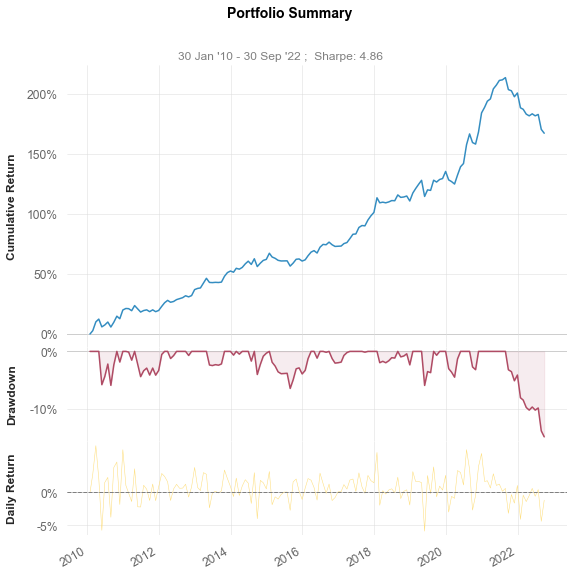

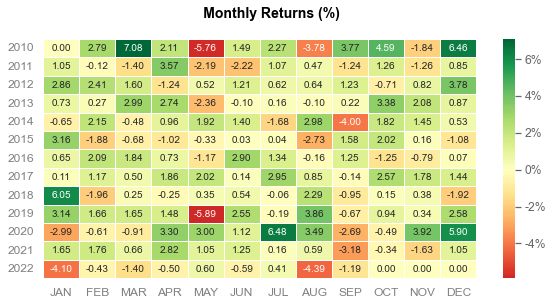

In [3]:
# 필요 라이브러리 import
import pandas_datareader as pdr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import math
import quantstats as qs

# pandas 설정 및 메타데이터 세팅
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

start_day = datetime(2010,1,1) # 시작일
end_day = datetime(2022,9,30) # 종료일

# RU : Risky Universe
# DU : Defence Universe
# CU : Canaria Universe
RU = ['SPY', 'QQQ', 'IWM', 'VGK', 'EWJ', 'EEM', 'VNQ', 'GLD', 'DBC', 'HYG', 'LQD', 'TLT']
DU = ['LQD','SHY','IEF']
CU = ['VWO', 'BND']
TU = list(set(RU+DU+CU)) # LQD 중복 제거

# 데이터 추출 함수
def get_price_data(TU, CU):
    df_TU = pd.DataFrame(columns=TU)
    df_CU = pd.DataFrame(columns=CU)
    
    for ticker in TU:
        df_TU[ticker] = pdr.get_data_yahoo(ticker, start_day - timedelta(days=365), end_day)['Adj Close']  
    
    for ticker in CU:
        df_CU[ticker] = pdr.get_data_yahoo(ticker, start_day - timedelta(days=365), end_day)['Adj Close']  
     
    return df_TU, df_CU

# 각 자산 군의 데이터 추출
df_TU, df_CU = get_price_data(TU, CU)

# 모멘텀 지수 계산 함수
def get_momentum(x):
    temp_list = [0 for i in range(len(x.index))]
    momentum = pd.Series(temp_list, index=x.index)

    try:
        before1 = df_TU[x.name-timedelta(days=35):x.name-timedelta(days=30)].iloc[-1][TU]
        before3 = df_TU[x.name-timedelta(days=95):x.name-timedelta(days=90)].iloc[-1][TU]        
        before6 = df_TU[x.name-timedelta(days=185):x.name-timedelta(days=180)].iloc[-1][TU]        
        before12 = df_TU[x.name-timedelta(days=370):x.name-timedelta(days=365)].iloc[-1][TU]

        momentum = 12 * (x / before1 - 1) + 4 * (x / before3 - 1) + 2 * (x / before6 - 1) + (x / before12 - 1)
    except Exception as e:
        #print("Error : ", str(e))
        pass
    
    return momentum

# 각 자산별 모멘텀 지수 계산
mom_col_list = [col+'_M' for col in df_TU[TU].columns]
df_TU[mom_col_list] = df_TU[TU].apply(lambda x: get_momentum(x), axis=1)

# 백테스트할 기간 데이터 추출
df_TU = df_TU[start_day:end_day]

# 매월 말일 데이터만 추출(리밸런싱에 사용)
df_TU = df_TU.resample(rule='M').last()

# 카나리아를 통한 안전자산 비중 측정
def get_canaria_ratio(x):
    asset = pd.Series([0, 0.0], index=['MMT_ASSET', 'RATIO'])
    
    # 모멘텀 > 0 갯수 계산
    momentum_asset = [1 if x[ticker+'_M'] > 0 else 0 for ticker in CU]
    
    # 공격 자산 비중 계산
    ratio =  float(sum(momentum_asset) / 2)

    asset['MMT_ASSET'] = int(sum(momentum_asset))
    asset['RATIO'] = round(ratio, 2)
    
    return asset

# 매월 선택할 자산과 가격
df_TU[['MMT_ASSET', 'RATIO']] = df_TU.apply(lambda x: get_canaria_ratio(x), axis=1)


# 모멘텀 지수 계산 함수
def get_momentum_RU(x):
    asset = pd.Series([0, 0, 0, 0, 0, 0], index=['RRANK1', 'RRANK2', 'RRANK3', 'RRANK4', 'RRANK5', 'RRANK6'])
    
    momentum_cols = [ticker + '_M' for ticker in RU]
    select_momentum = x[momentum_cols].sort_values(ascending=False).index
    
    asset['RRANK1'] = select_momentum[0][:3]
    asset['RRANK2'] = select_momentum[1][:3]
    asset['RRANK3'] = select_momentum[2][:3]
    asset['RRANK4'] = select_momentum[3][:3]
    asset['RRANK5'] = select_momentum[4][:3]
    asset['RRANK6'] = select_momentum[5][:3]
    
    return asset

# 모멘텀 지수 계산 함수
def get_momentum_DU(x):
    asset = pd.Series([0, 0, 0], index=['DRANK1', 'DRANK2', 'DRANK3'])
    
    momentum_cols = [ticker + '_M' for ticker in DU]
    select_momentum = x[momentum_cols].sort_values(ascending=False).index

    asset['DRANK1'] = select_momentum[0][:3]
    asset['DRANK2'] = select_momentum[1][:3]
    asset['DRANK3'] = select_momentum[2][:3]
    
    return asset


# 공격자산 모멘텀 상위 6개 자산군 구하기
df_TU[['RRANK1', 'RRANK2', 'RRANK3', 'RRANK4', 'RRANK5', 'RRANK6']] = df_TU.apply(lambda x : get_momentum_RU(x), axis=1)

# 방어자산 모멘텀 상위 3개 자산구하기
df_TU[['DRANK1', 'DRANK2', 'DRANK3']] = df_TU.apply(lambda x : get_momentum_DU(x), axis=1)

# 각 자산별 수익률 계산
profit_col_list = [col+'_P' for col in df_TU[TU].columns]
df_TU[profit_col_list] = df_TU[TU].pct_change() * 100

# 매월 수익률 & 누적 수익률 계산
df_TU['PROFIT'] = 0

for i in range(len(df_TU)):
    profit = 0
    log_profit = 0
        
    if i != 0:
        RU_ratio = df_TU.iloc[i-1]['RATIO']
        DU_ratio = (1.0 - RU_ratio)
        
        profit1 = df_TU[df_TU.iloc[i-1]['DRANK1'] + '_P'].iloc[i] * DU_ratio
        profit2 = df_TU[df_TU.iloc[i-1]['RRANK1'] + '_P'].iloc[i] * (RU_ratio/6)
        profit3 = df_TU[df_TU.iloc[i-1]['RRANK2'] + '_P'].iloc[i] * (RU_ratio/6)
        profit4 = df_TU[df_TU.iloc[i-1]['RRANK3'] + '_P'].iloc[i] * (RU_ratio/6)
        profit5 = df_TU[df_TU.iloc[i-1]['RRANK4'] + '_P'].iloc[i] * (RU_ratio/6)
        profit6 = df_TU[df_TU.iloc[i-1]['RRANK5'] + '_P'].iloc[i] * (RU_ratio/6)
        profit7 = df_TU[df_TU.iloc[i-1]['RRANK6'] + '_P'].iloc[i] * (RU_ratio/6)
        
        profit = profit1 + profit2 + profit3 + profit4 + profit5 + profit6 + profit7
    
    df_TU.loc[df_TU.index[i], 'PROFIT'] = profit
    
# QuantStats의 기본 리포트
qs.reports.basic(df_TU['PROFIT']/100)

In [2]:
df_TU.tail(10)

,DBC,EEM,SPY,BND,VWO,SHY,HYG,GLD,IEF,TLT,VNQ,LQD,IWM,VGK,EWJ,QQQ,DBC_M,EEM_M,SPY_M,BND_M,VWO_M,SHY_M,HYG_M,GLD_M,IEF_M,TLT_M,VNQ_M,LQD_M,IWM_M,VGK_M,EWJ_M,QQQ_M,MMT_ASSET,RATIO,RRANK1,RRANK2,RRANK3,RRANK4,RRANK5,RRANK6,DRANK1,DRANK2,DRANK3,DBC_P,EEM_P,SPY_P,BND_P,VWO_P,SHY_P,HYG_P,GLD_P,IEF_P,TLT_P,VNQ_P,LQD_P,IWM_P,VGK_P,EWJ_P,QQQ_P,PROFIT
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-12-31,20.7800,48.4384,469.5238,83.2581,48.3006,84.9543,83.8212,170.9600,113.5776,145.8358,113.4197,129.6455,220.2906,66.4605,66.3158,395.8849,1.5230,-0.1501,1.5786,-0.0835,0.0659,-0.0720,0.3465,0.5039,-0.1344,-0.2083,2.6268,-0.0436,0.6687,1.0878,0.2283,1.2705,1.0000,0.5000,VNQ,SPY,DBC,QQQ,VGK,IWM,LQD,SHY,IEF,6.6735,1.5071,4.6248,-0.3103,1.5402,-0.2123,2.2842,3.2991,-0.5240,-2.0138,9.7056,-0.0341,2.2715,5.1984,2.2770,1.1523,1.0479
2022-01-31,22.4200,48.4285,444.7605,81.5389,48.5057,84.3683,81.5958,168.0900,111.1776,140.1280,103.8679,124.9887,199.2865,64.0841,63.4635,361.2568,1.9544,-0.2807,-0.4275,-0.4400,-0.0432,-0.1661,-0.4010,-0.2224,-0.4559,-0.7403,-0.7894,-0.7326,-1.8556,-0.5266,-0.8733,-1.1711,0.0000,0.0000,DBC,GLD,EEM,HYG,SPY,VGK,SHY,IEF,LQD,7.8922,-0.0205,-5.2741,-2.0649,0.4246,-0.6897,-2.6549,-1.6788,-2.1131,-3.9139,-8.4217,-3.5919,-9.5347,-3.5756,-4.3011,-8.7470,-4.1010
2022-02-28,23.8700,46.3362,431.6325,80.6109,46.6990,84.0037,80.8949,178.3800,110.8396,137.8397,100.2505,122.3247,201.3463,60.6949,62.3344,345.0871,2.6508,-0.5846,-0.1881,-0.3951,-0.3716,-0.1591,-0.2079,1.3261,-0.2544,-0.6692,-0.3082,-0.6489,-0.0260,-0.7595,-0.3418,-0.7075,0.0000,0.0000,DBC,GLD,IWM,SPY,HYG,VNQ,SHY,IEF,LQD,6.4674,-4.3202,-2.9517,-1.1380,-3.7246,-0.4322,-0.8590,6.1217,-0.3041,-1.6330,-3.4827,-2.1314,1.0336,-5.2888,-1.7790,-4.4760,-0.4322
2022-03-31,26.0600,44.7695,447.8578,78.3924,45.1788,82.8262,79.8536,180.6500,106.3385,130.3352,106.5301,118.7849,203.6769,60.7905,61.0172,361.1953,2.7284,-0.8692,0.7076,-0.7899,-0.7112,-0.3896,-0.4124,0.4871,-1.0261,-1.3887,0.9206,-0.9445,-0.1355,-0.0670,-0.7075,0.5646,0.0000,0.0000,DBC,VNQ,SPY,QQQ,GLD,VGK,SHY,LQD,IEF,9.1747,-3.3811,3.7590,-2.7521,-3.2553,-1.4018,-1.2871,1.2726,-4.0609,-5.4444,6.2639,-2.8938,1.1575,0.1575,-2.1131,4.6679,-1.4018
2022-04-30,27.5300,42.0229,408.5497,75.2781,42.5443,82.4146,76.5155,176.9100,101.8422,118.0525,102.1753,110.8271,183.5146,56.9935,56.0752,312.0882,2.4755,-1.8456,-1.6814,-1.0572,-1.6953,-0.2537,-1.0108,0.1784,-1.1072,-2.2443,-0.6299,-1.6939,-2.0565,-1.7442,-1.9687,-2.6421,0.0000,0.0000,DBC,GLD,VNQ,HYG,SPY,LQD,SHY,IEF,LQD,5.6408,-6.1351,-8.7769,-3.9727,-5.8313,-0.4969,-4.1803,-2.0703,-4.2283,-9.4239,-4.0878,-6.6993,-9.8992,-6.2460,-8.0993,-13.5957,-0.4969
2022-05-31,28.8000,42.2807,409.4719,75.9027,42.7402,82.9060,77.7626,171.1400,102.4720,115.3925,97.3880,112.8929,183.8718,58.3698,57.0458,307.1366,2.5518,-0.6975,-0.3757,-0.3718,-0.6358,-0.0582,-0.1236,-0.5517,-0.4999,-1.4481,-0.8478,-0.4145,-0.8114,-0.0886,-0.4935,-1.1217,0.0000,0.0000,DBC,VGK,HYG,SPY,LQD,EWJ,SHY,LQD,IEF,4.6131,0.6135,0.2257,0.8297,0.4604,0.5962,1.6299,-3.2615,0.6184,-2.2533,-4.6854,1.8639,0.1946,2.4148,1.7308,-1.5866,0.5962
2022-06-30,26.6400,40.1000,375.7067,74.6412,41.0946,82.4132,72.2805,168.4600,101.5872,113.9217,90.1337,108.8030,168.4884,52.5924,52.8300,279.7772,0.1104,-1.6948,-2.1492,-0.6938,-1.4004,-0.1782,-1.6285,-0.4461,-0.5733,-1.2987,-2.0649,-1.2661,-2.4557,-2.3687,-2.0480,-2.7561,0.0000,0.0000,DBC,GLD,LQD,TLT,HYG,EEM,SHY,IEF,LQD,-7.5000,-5.1577,-8.2460,-1.6620,-3.8502,-0.5943,-7.0499,-1.5660,-0.8634,-1.2746,-7.4489,-3.6228,-8.3664,-9.8980,-7.3902,-8.9079,-0.5943
2022-07-31,26.1100,39.9600,410.3045,76.4190,40.7690,82.7510,77.1225,164.1000,104.5956,116.6912,97.8995,113.6386,186.2864,55.2210,56.1500,314.8941,-0.1397,-0.8053,0.8423,0.1798,-0.7516,0.0176,0.6476,-0.7485,0.3463,-0.1869,0.7086,0.3560,1.0020,-0.0105,0.3938,1.0393,1.0000,0.5000,QQQ,IWM,SPY,VNQ,HYG,EWJ,LQD,IEF,SHY,-1.9895,-0.3491,9.2087,2.3818,-0.7923,0.4098,6.6989,-2.5882,2.9615,2.4310,8.6160,4.4444,10.5633,4.9981,6.2843,12